<a href="https://colab.research.google.com/github/Kebatotkulov/CompEcon/blob/main/model_in_quotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre settings

In [166]:
import pandas as pd
import numpy as np
def merger(df1, df2, left, right, method):
  ndata = pd.merge(df1, df2, left_on=  left,
                   right_on= right, 
                   how = method)
  return ndata

# Data Simulation 

Основная проблема в реальных данных: у нас расположено n_i-ое количество магазинов в каждом индексе, а значит у всех магазнов индексных зон будут одинаковые показатели revenue. Как можно рабоатать с такими данными?

In [167]:
from itertools import product
def data_gen(seed_m=42):
  np.random.seed(seed_m)
  synt_cons = {'postcode_id':[i for i in range(100)], 
             'income':abs(np.random.normal(80000, 20000, 100)), 
             'population':np.random.uniform(4000, 7000 ,100),
             'vehicle': np.random.randint(2,size = 100)}
  synt_stores = {'shopid':list(range(10)), 
               'size':abs(np.random.normal(500,200, 10)), 
               'chain': np.random.uniform(1, 4, 10)}
  cons, shops = pd.DataFrame(synt_cons).astype(int), pd.DataFrame(synt_stores).astype(int)
  a, b = list(cons['postcode_id']), list(shops['shopid'])
  df1 = pd.DataFrame(tuple(product(a, b)), columns=['postcode', 'shop'])
  m1 = merger(cons, df1, 'postcode_id', 'postcode', 'left')
  merged_conshops = merger(m1,shops, 'shop', 'shopid', 'left')
  merged_conshops['km'] = np.random.uniform(2, 10, 1000) 
  return cons, shops, merged_conshops

In [168]:
cons, shops, merged_conshops = data_gen(seed_m=42)

Calcualte "theoretical" valuations based on EllicksonGriecoKhvastunov2020 parameters

$u_{sti} = u_{st} + \epsilon_{sti} = \delta_0 d_{st} + \delta_1 d_{st} z_t + \gamma_0 x_s + \gamma_1 (x_s \otimes z_t) + \epsilon_{sti} $



In [169]:
def util_sum(data = merged_conshops):
  data['dist*vehicle'] = data['km'] * data['vehicle']
  data['log(income)'] = np.log(data['income'])
  data['dist*log(inc)'] = data['km'] * data['log(income)']
  data['log(size)'] = np.log(data['size'])
  data['log(size)*log(inc)'] = data['log(size)'] * data['log(income)']
  est_cols = ['km','vehicle','dist*vehicle', 'dist*log(inc)', 'log(size)', 'log(size)*log(inc)']
  return data[est_cols] 


In [170]:
est_data = util_sum()

In [171]:
def util(data, params):
  util = data.values.dot(np.array(params))
  return util

In [172]:
params = [-0.150, 1.4, 0.3, -1.4, 0.154, 0.126]#[118.10406005,   1.4,  -0.36093365,  -9.39329557, 26.44946197,  -2.00253653]#[-0.150, 1.4, 0.3, -1.4, 0.154, 0.126]
u = util(est_data, params)

In [173]:
u_v = u.reshape(100,-1) #array of 100 preference arrays 

## Estimation
Try Platform Markets (CompEcon) code

In [174]:
def solve_sa(F,x0,tol=1e-6,maxiter=100,callback=None,raise_error=True):
    '''Computes the solution of fixed point equation x = F(x)
    with given initial value x0 and algorithm parameters
    Method: successive approximations
    '''
    for i in range(maxiter):  # main loop
        x1 = F(x0)  # update approximation
        err = np.amax(np.abs(x0-x1))  # allow for x to be array
        if callback != None: callback(iter=i,err=err,x=x1,x0=x0)
        if err<tol:
            break  # break out if converged
        x0 = x1  # get ready to the next iteration
    else:
        if raise_error:
            raise RuntimeError('Failed to converge in %d iterations'%maxiter)
    return x1

def mnewton(fun,grad,x0,tol=1e-6,maxiter=100,callback=None):
    '''Multinomial Newton method for solving systems of equation F(x)=0,
    x is vector of m elements, F(x) is a m-valued function.
    Given tolerance and number of iterations are used.
    Callback function is invoked at each iteration if given.
    '''
    # conversion to array function of array argument
    npfun = lambda x: np.asarray(fun(x))
    npgrad = lambda x: np.asarray(grad(x))
    for i in range(maxiter):
        x1 = x0 - np.linalg.inv(npgrad(x0)) @ npfun(x0)  # matrix version
        err = np.amax(np.abs(x1-x0)) # max over vector elements
        if callback != None: callback(iter=i,err=err,x0=x0,x1=x1,fun=fun)
        if err<tol: break
        x0 = x1
    else:
        raise RuntimeError('Failed to converge in %d iterations'%maxiter)
    return x1

class model:
    '''Simple platform equilibrium model'''

    def __init__(self, util_vec=u_v[0], m=10,n=1):
        '''Define default model parameters'''
        self.m,self.n = m,n  # number of products and consumer types
        self.c = util_vec.reshape(m, n)    # valuations (random uniform)
        self.p = np.array(n*[1/n])  # population composition (from symmetric Dirichlet distribution)

    def __repr__(self):
        return 'Number of platform products = {:d}\nNumber of consumer types = {:d}\nPopulation composition = {}\nValuations:\n{}'.format(self.m,self.n,self.p,self.c)

    def ccp(self,u):
        '''Conditional choice probabilities
        Input: m*n array of utilities, to be reshaped
        Output: m by n matrix
        '''
        u = np.asarray(u).reshape((self.m,self.n),order='F')   # convert to matrix, column-major reshaping
        u = u - np.amax(u,axis=0) # de-max by column (avoid exp of large numbers)
        e = np.exp(u)
        esum = e.sum(axis=0)  # sums of exps
        return e/esum         # matrix of choice probabilities

    def shares(self,ccp):
        '''Market shares from choice probabilities
        Input: m by n matrix of ccps
        Output: market shares, m by 1 column vector
        '''
        out = ccp @ self.p  # one-dim vector
        return out[:,np.newaxis]  # column vector

    def F(self,u):
        '''Fixed point equation u=F(u)
        Input: m*n array of utilities
        Output: m*n array of utilities
        '''
        ccp = self.ccp(u)     # matrix of choice probabilities
        sh = self.shares(ccp) # market shares
        u1 = self.c + sh     # updated utilities
        return u1.reshape(self.m*self.n,order='F') # return one dimensional array

    def G(self,u):
        '''LHS of the equation is standard form u-F(u)=0.
        Input: m*n array of utilities
        Output: m*n array of equation residuals
        '''
        return u - self.F(u)

    def dGa(self,u):
        '''Jacobian of G(u) computed in a direct and inefficient but more clear way
        Input: m*n array of utilities
        Output: m*n by m*n matrix of first derivatives
        '''
        ccp = self.ccp(u)
        out = np.ones((self.m*self.n,self.m*self.n))
        for i in range(self.m):
            for j in range(self.n):
                for k in range(self.m):
                    for l in range(self.n):
                        # formula for derivatives of dg(i,j)/du(k,l)
                        if i==k and j==l:
                            val = 1 - ccp[i,j]*(1-ccp[i,j])*self.p[l]
                        elif i==k and j!=l:
                            val = - ccp[i,l]*(1-ccp[i,l])*self.p[l]
                        elif i!=k:
                            val = ccp[i,l]*ccp[k,l]*self.p[l]
                        else:
                            raise error
                        # column-major indexing
                        out[j*self.m+i,l*self.m+k] = val
        return out

    def dGb(self,u):
        '''Jacobian of G(u)
        Input: m*n array of utilities
        Output: m*n by m*n matrix of first derivatives
        '''
        ccp = self.ccp(u)
        out = np.empty((self.m*self.n,self.m*self.n))
        # step 1 and 2
        for l in range(self.n):
            block = self.p[l]*np.outer(ccp[:,l],ccp[:,l])
            block -= np.diag(self.p[l]*ccp[:,l]) # add diagonal elements
            out[:,l*self.m:(l+1)*self.m] = np.tile(block,(self.n,1))
        # step 3
        out += np.eye(self.m*self.n)
        return out


def printiter(**kwargs):
    print('iter %d, err = %1.3e'%(kwargs['iter'],kwargs['err']))

md = model(u_v[0])
# md = model(m=3,n=2)
print(md)

x0 = md.c.reshape(md.m*md.n,order='F')
print('x0=',x0)

print('dG loops :',md.dGa(x0),sep='\n')
print('dG matrix:',md.dGb(x0),sep='\n')
print('Differences:',md.dGa(x0)-md.dGb(x0) > 1e-8,sep='\n')

Number of platform products = 10
Number of consumer types = 1
Population composition = [1.]
Valuations:
[[ -27.10867254]
 [ -87.17651798]
 [ -89.36141966]
 [-101.18156968]
 [-112.58879485]
 [-143.80037775]
 [ -84.64990544]
 [ -63.41558665]
 [-120.60071412]
 [ -56.27810868]]
x0= [ -27.10867254  -87.17651798  -89.36141966 -101.18156968 -112.58879485
 -143.80037775  -84.64990544  -63.41558665 -120.60071412  -56.27810868]
dG loops :
[[1.00000000e+00 8.18212638e-27 9.20397520e-28 6.76938965e-33
  7.52410013e-38 2.09621750e-51 1.02367022e-25 1.70650493e-16
  2.49414810e-41 2.14721160e-13]
 [8.18212638e-27 1.00000000e+00 7.53080883e-54 5.53880017e-59
  6.15631382e-64 1.71515165e-77 8.37579909e-52 1.39628390e-42
  2.04074350e-67 1.75687567e-39]
 [9.20397520e-28 7.53080883e-54 1.00000000e+00 6.23052945e-60
  6.92516310e-65 1.92935339e-78 9.42183529e-53 1.57066291e-43
  2.29560772e-68 1.97628823e-40]
 [6.76938965e-33 5.53880017e-59 6.23052945e-60 1.00000000e+00
  5.09335656e-70 1.41901130e-83 6.

In [175]:
print('SA:')
x = solve_sa(md.F,x0=x0,tol=1e-10)
print('SA: Equilibrium found!')
ccp = md.ccp(x)
shares = md.shares(ccp).squeeze()  # make one-dim array
print('Equilibrium choice probabilities:',ccp,'Equilibrium market shares:',shares,sep='\n')

SA:
SA: Equilibrium found!
Equilibrium choice probabilities:
[[1.00000000e+00]
 [3.01003608e-27]
 [3.38595325e-28]
 [2.49031928e-33]
 [2.76796175e-38]
 [7.71155322e-52]
 [3.76587227e-26]
 [6.27788080e-17]
 [9.17545809e-42]
 [7.89915003e-14]]
Equilibrium market shares:
[1.00000000e+00 3.01003608e-27 3.38595325e-28 2.49031928e-33
 2.76796175e-38 7.71155322e-52 3.76587227e-26 6.27788080e-17
 9.17545809e-42 7.89915003e-14]


In [176]:
l = []
for i in range(len(u_v)):
  md = model(u_v[i])
  x0 = md.c.reshape(md.m*md.n,order='F')
  x = solve_sa(md.F,x0=x0,tol=1e-10)
  ccp = md.ccp(x)
  l.append(ccp)


In [177]:
ccp = np.array(l).reshape(1,-1)

In [178]:
merged_conshops['probs'] = ccp[0]

In [179]:
merged_conshops.head(15)

,postcode_id,income,population,vehicle,postcode,shop,shopid,size,chain,km,dist*vehicle,log(income),dist*log(inc),log(size),log(size)*log(inc),probs
0,0,89934,5252,1,0,0,0,436,1,2.413454,2.413454,11.406831,27.529860,6.077642,69.326640,1.000000e+00
1,0,89934,5252,1,0,1,1,651,1,6.250837,6.250837,11.406831,71.302244,6.478510,73.899267,3.010036e-27
2,0,89934,5252,1,0,2,2,345,3,6.325081,6.325081,11.406831,72.149132,5.843544,66.656326,3.385953e-28
3,0,89934,5252,1,0,3,3,452,2,7.099439,7.099439,11.406831,80.982106,6.113682,69.737742,2.490319e-33
4,0,89934,5252,1,0,4,4,402,1,7.808731,7.808731,11.406831,89.072874,5.996452,68.400518,2.767962e-38
5,0,89934,5252,1,0,5,5,516,2,9.806817,9.806817,11.406831,111.864703,6.246107,71.248286,7.711553e-52
6,0,89934,5252,1,0,6,6,962,3,6.130403,6.130403,11.406831,69.928471,6.869014,78.353689,3.765872e-26
7,0,89934,5252,1,0,7,7,126,1,4.583652,4.583652,11.406831,52.284943,4.836282,55.166652,6.277881e-17
8,0,89934,5252,1,0,8,8,637,2,8.361490,8.361490,11.406831,95.378101,6.456770,73.651283,9.175458e-42
9,0,89934,5252,1,0,9,9,177,1,4.166658,4.166658,11.406831,47.528365,5.176150,59.043467,7.899150e-14


Define choice decisions

In [180]:
#merged_conshops['ch_dec'] = merged_conshops.apply(lambda row: 1 if (row['probs']>0.5) else 0, axis =1)

Define revenues

In [181]:
# utility function is defined above/ should be used with .apply
def data_revenue(row, alpha = 0.3):
  '''This function defines individual contributions of existing individuals'''
  revenue  = alpha * row['probs'] * row['income'] * row['population']
  return revenue

In [182]:
merged_conshops['rev_0'] = merged_conshops.apply(lambda row: data_revenue(row), axis = 1)

In [183]:
merged_conshops.head() #see the result

,postcode_id,income,population,vehicle,postcode,shop,shopid,size,chain,km,dist*vehicle,log(income),dist*log(inc),log(size),log(size)*log(inc),probs,rev_0
0,0,89934,5252,1,0,0,0,436,1,2.413454,2.413454,11.406831,27.529860,6.077642,69.326640,1.000000e+00,1.417000e+08
1,0,89934,5252,1,0,1,1,651,1,6.250837,6.250837,11.406831,71.302244,6.478510,73.899267,3.010036e-27,4.265221e-19
2,0,89934,5252,1,0,2,2,345,3,6.325081,6.325081,11.406831,72.149132,5.843544,66.656326,3.385953e-28,4.797896e-20
3,0,89934,5252,1,0,3,3,452,2,7.099439,7.099439,11.406831,80.982106,6.113682,69.737742,2.490319e-33,3.528783e-25
4,0,89934,5252,1,0,4,4,402,1,7.808731,7.808731,11.406831,89.072874,5.996452,68.400518,2.767962e-38,3.922202e-30


In [184]:
 store_rev = pd.DataFrame(merged_conshops.groupby('shopid')['rev_0'].sum()).reset_index()

In [185]:
store_rev

,shopid,rev_0
0,0,2.115564e+09
1,1,9.888719e+08
2,2,8.977697e+08
3,3,1.029940e+09
4,4,1.873242e+09
5,5,9.737298e+08
6,6,1.781080e+09
7,7,1.268828e+09
8,8,9.076908e+08
9,9,9.831095e+08


Generate Random (almost random) Revenues

In [186]:
revs = list(store_rev['rev_0'])

In [187]:
store_rev['fict_rev'] = revs

In [188]:
store_rev

,shopid,rev_0,fict_rev
0,0,2.115564e+09,2.115564e+09
1,1,9.888719e+08,9.888719e+08
2,2,8.977697e+08,8.977697e+08
3,3,1.029940e+09,1.029940e+09
4,4,1.873242e+09,1.873242e+09
5,5,9.737298e+08,9.737298e+08
6,6,1.781080e+09,1.781080e+09
7,7,1.268828e+09,1.268828e+09
8,8,9.076908e+08,9.076908e+08
9,9,9.831095e+08,9.831095e+08


In [189]:
#now join the datasets 
data_w_rev = merger(merged_conshops, store_rev, 'shopid', 'shopid', 'left')

In [190]:
est_data

,km,vehicle,dist*vehicle,dist*log(inc),log(size),log(size)*log(inc)
0,2.413454,1,2.413454,27.529860,6.077642,69.326640
1,6.250837,1,6.250837,71.302244,6.478510,73.899267
2,6.325081,1,6.325081,72.149132,5.843544,66.656326
3,7.099439,1,7.099439,80.982106,6.113682,69.737742
4,7.808731,1,7.808731,89.072874,5.996452,68.400518
...,...,...,...,...,...,...
995,3.601202,1,3.601202,40.439127,6.246107,70.139667
996,3.339861,1,3.339861,37.504436,6.869014,77.134510
997,2.836543,1,2.836543,31.852507,4.836282,54.308262
998,7.091442,1,7.091442,79.632225,6.456770,72.505272


# GMM
Follow the [QuantEcon](https://notes.quantecon.org/submission/5b3b1856b9eab00015b89f90) for details

In [191]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.pyplot import figure

In [192]:
def data_preparate(): #write this function
  pass 


In [128]:
def err_vec(params = [-0.150, 1.4, 0.3, -1.4, 0.154, 0.126], revs = [1.8e9, 1.2e9, 9.1e8, 0.7e9, 1.5e9, 9.3e9, 1.4e9, 1.3e9, 8.7e8, 9.2e8], simple = False):
  'define error vectors'
  global u, data_moms, fict_moms, store_rev, merged_conshops
  u = util(est_data, params)
  u_v = u.reshape(100,-1)
  l = []
  for i in range(len(u_v)):
    md = model(u_v[i])
    x0 = md.c.reshape(md.m*md.n,order='F')
    x = solve_sa(md.F,x0=x0,tol=1e-10)
    ccp = md.ccp(x)
    l.append(ccp)
  merged_conshops['probs'] = np.array(l).reshape(1,-1)[0]
  merged_conshops['rev_0'] = merged_conshops.apply(lambda row: data_revenue(row), axis = 1)
  store_rev = pd.DataFrame(merged_conshops.groupby('shopid')['rev_0'].sum()).reset_index()
  store_rev['fict_rev'] = revs
  data_moms, fict_moms = store_rev['rev_0'], store_rev['fict_rev']
  if simple:
      err_vec = fict_moms - data_moms
  else:
      err_vec = (fict_moms - data_moms) ** 2 #define errors 
    
  return err_vec

In [67]:
#revs = [1.8e9, 1.2e9, 9.1e8, 0.7e9, 1.5e9, 9.3e9, 1.4e9, 1.3e9, 8.7e8, 9.2e8]

In [129]:
def criterion(params, *args):
    revs, W = args 
    err = err_vec( params, revs, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val

In [131]:
W_hat = np.eye(store_rev.shape[0])
gmm_args = (revs, W_hat)
params_init = [-0.150, 1.4, 0.3, -1.4, 0.154, 0.126]
results = opt.minimize(criterion, list(np.zeros(6)) , args=(gmm_args),
                       method='BFGS')

In [132]:
results.x

array([ 4.35472746,  0.        , -6.93710038, -0.56723707, 64.03949365,
       -5.60670541])

In [ ]:
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='Nelder-Mead')
results.x 

array([-0.15 ,  1.4  ,  0.3  , -1.4  ,  0.154,  0.126])

Try other simulations 

In [133]:
# this is the process checker line of code (i mean the one to check the revenue vals on the last iteration)
store_rev

,shopid,rev_0,fict_rev
0,0,1.009047e+09,2.115564e+09
1,1,1.579279e+09,9.888719e+08
2,2,2.494972e+08,8.977697e+08
3,3,9.165043e+08,1.029940e+09
4,4,1.090868e+09,1.873242e+09
5,5,1.115648e+09,9.737298e+08
6,6,2.211031e+09,1.781080e+09
7,7,2.761745e+09,1.268828e+09
8,8,1.283557e+09,9.076908e+08
9,9,6.026483e+08,9.831095e+08


In [134]:
def gmm_opt(init_params=[-0.150, 1.4, 0.3, -1.4, 0.154, 0.126]):
  results = opt.minimize(criterion, init_params, args=(gmm_args), method='BFGS')
  return results.x

In [135]:
R, M, D= [], [], []
init_params =list(np.zeros(6))

In [140]:
k = 0
while k < 20:
  r = gmm_opt(init_params) 
  R.append(list(r))
  d = data_moms[0]-fict_moms[0]
  D.append(d)
  if abs(d) > 100:
    init_params = list(r)
    M.append(init_params)
  else: 
    break
  k+=1

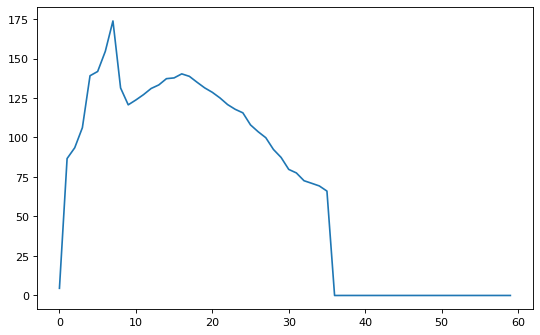

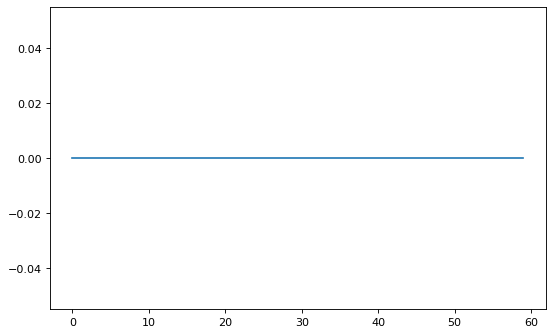

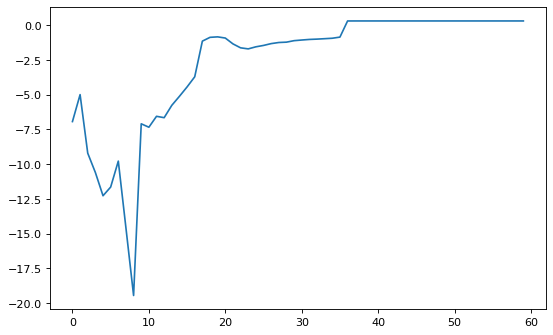

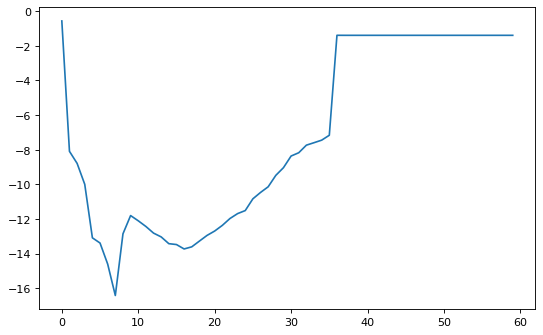

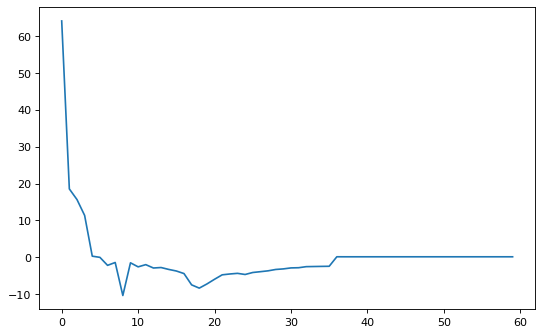

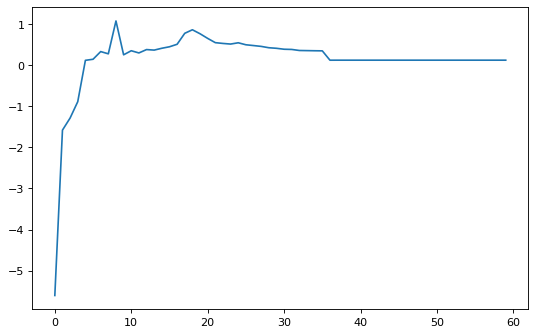

In [141]:
for i in range(len(R[0])):
  figure(figsize=(8, 5), dpi=80)
  plt.plot(np.asarray(R)[:,i])
  plt.show()

Not ideal, but still close enough 



In [142]:
R[-1] # and this is the final estimation result (it is not jumping) 

[-0.18176087352845843,
 0.0,
 0.2979049163774473,
 -1.3971630106032906,
 0.1691866379136578,
 0.12467095800816419]

Let's check the model convergence to other generated values

In [209]:
# let's generate some data 
cons, shops, merged_conshops = data_gen(seed_m=10)
est_data = util_sum()

yes, there are thousands of repetitions, but... i will fix this either way

In [210]:
params = [-0.150, 1.4, 0.3, -1.4, 0.154, 0.126]#[118.10406005,   1.4,  -0.36093365,  -9.39329557, 26.44946197,  -2.00253653]#[-0.150, 1.4, 0.3, -1.4, 0.154, 0.126]
u1 = util(est_data, params)

In [211]:
u_v1 = u.reshape(100,-1) #array of 100 preference arrays 

In [200]:
m = []
for i in range(len(u_v1)):
  md = model(u_v1[i])
  x0 = md.c.reshape(md.m*md.n,order='F')
  x = solve_sa(md.F,x0=x0,tol=1e-10)
  ccp1 = md.ccp(x)
  m.append(ccp1)


In [212]:
ccp1 = np.array(m).reshape(1,-1)
merged_conshops['probs'] = ccp1[0]
merged_conshops['rev_0'] = merged_conshops.apply(lambda row: data_revenue(row), axis = 1)
store_rev1 = pd.DataFrame(merged_conshops.groupby('shopid')['rev_0'].sum()).reset_index()

In [213]:
#add a column with one of the previous rev_calcs
revs = store_rev['rev_0']
store_rev1['rev_former'] = revs

In [214]:
store_rev1

,shopid,rev_0,rev_former
0,0,2.293018e+09,2.115564e+09
1,1,9.491089e+08,9.888719e+08
2,2,1.028592e+09,8.977697e+08
3,3,1.108600e+09,1.029940e+09
4,4,1.442325e+09,1.873242e+09
5,5,1.008742e+09,9.737298e+08
6,6,2.213383e+09,1.781080e+09
7,7,1.240522e+09,1.268828e+09
8,8,9.801388e+08,9.076908e+08
9,9,1.087179e+09,9.831095e+08


The process itself

In [215]:
R, M, D= [], [], []
init_params =list(np.zeros(6))

In [224]:
k = 0
while k<10:
  r = gmm_opt(init_params) 
  R.append(list(r))
  d = np.asarray(data_moms-fict_moms)
  D.append(d)
  if abs(d[0]) > 1000000:
    init_params = list(r)
    M.append(init_params)
  else: 
    break
  k+=1

In [225]:
R

[[-19.965534407701007,
  0.0,
  -1.7396702843319676,
  1.6537098637893837,
  2.648101902741897,
  -0.22030652273020618],
 [-12.982509599822993,
  0.0,
  -2.1550085480517316,
  0.9756477318898249,
  0.006531930526603724,
  0.012737070882772789],
 [1.8038711038862987,
  0.0,
  -1.7897652774448813,
  -0.36596201320826643,
  -4.742165336982964,
  0.43980336580170065],
 [43.548667131269944,
  0.0,
  -0.11289381814475119,
  -4.139148600832298,
  -7.547580787445716,
  0.6941023953095931],
 [52.0459468854753,
  0.0,
  0.10556614322132646,
  -4.977688514950048,
  -7.9105472692060035,
  0.7218986030002712],
 [59.38181150477122,
  0.0,
  0.07366577634281364,
  -5.642809956402061,
  -7.8698572012192045,
  0.7150986519106887],
 [69.45309757227285,
  0.0,
  -0.01694513321623769,
  -6.565689473752256,
  -6.895499291993604,
  0.6284678965240789],
 [75.37256798053126,
  0.0,
  -1.1480930894894472,
  -7.0177770956214625,
  -16.3084416647839,
  1.4748748695424019],
 [77.80130869959481,
  0.0,
  -1.204054

In [226]:
df_res = pd.DataFrame({'params':R, 'delta1':D})

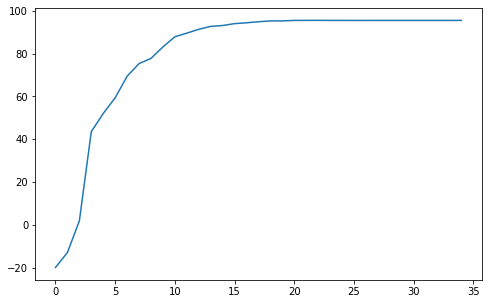

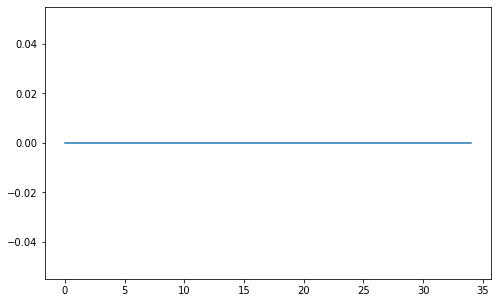

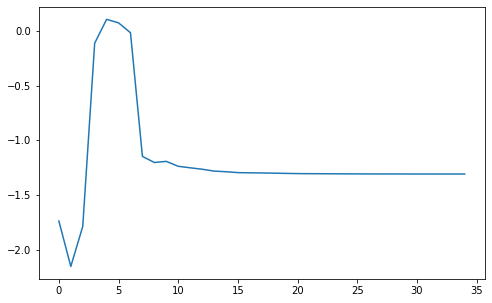

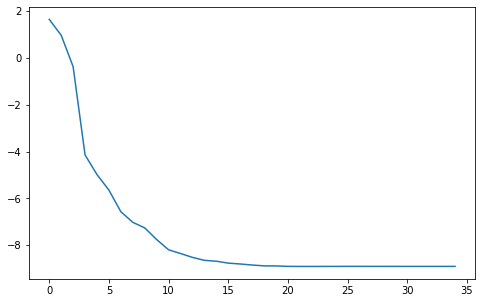

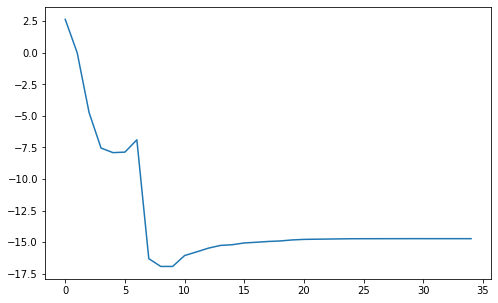

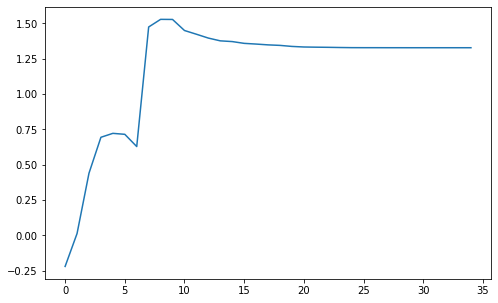

In [227]:
for i in range(len(R[0])):
  figure(figsize=(8, 5))
  plt.plot(np.asarray(R)[:, i])
  plt.show()

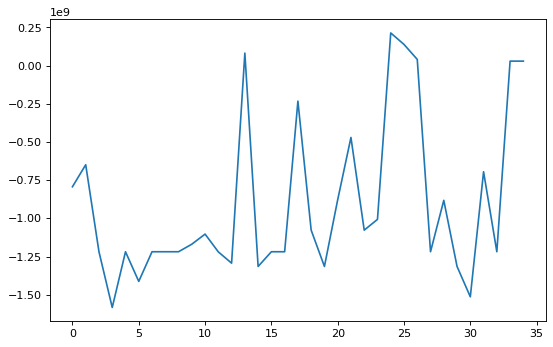

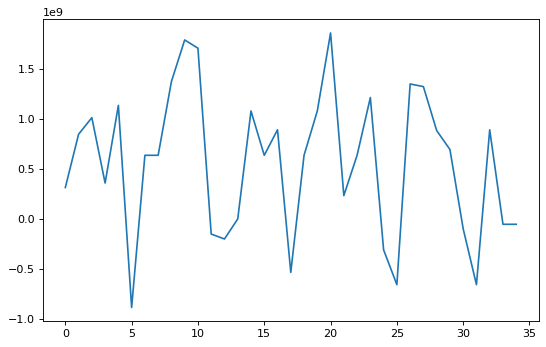

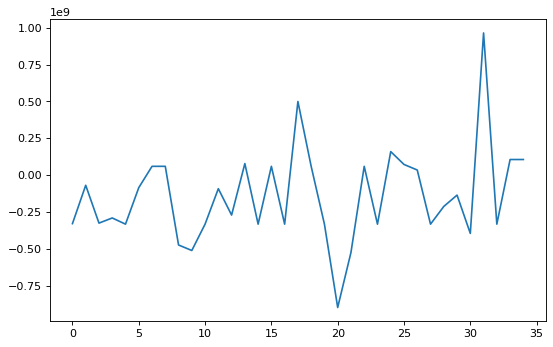

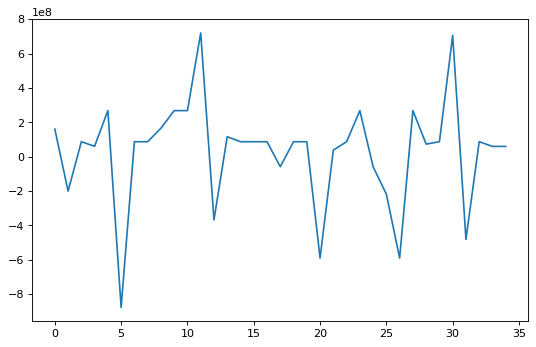

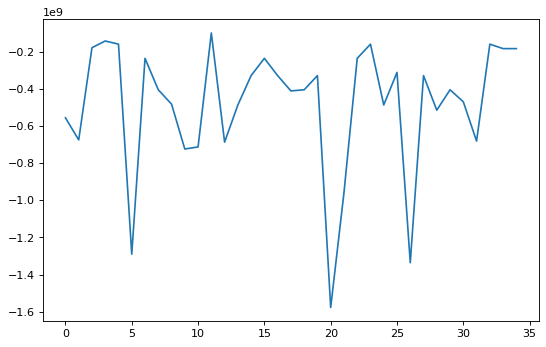

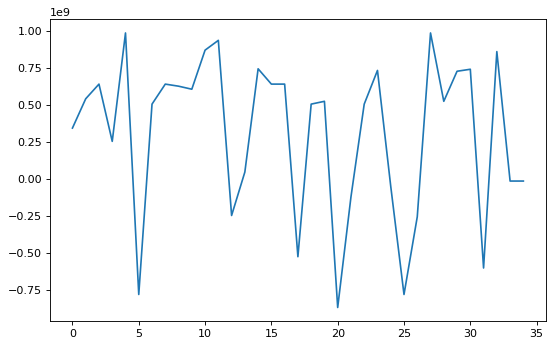

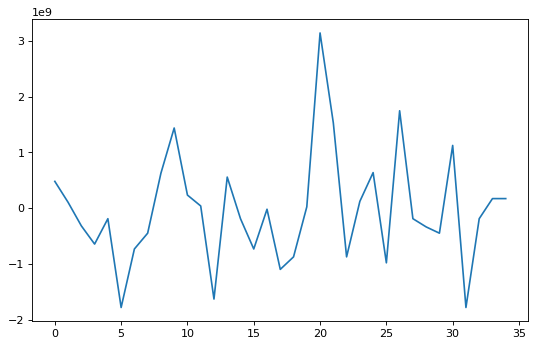

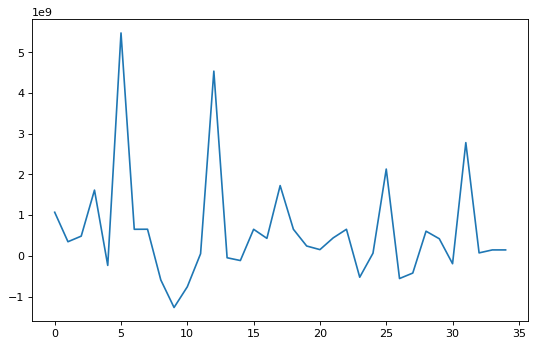

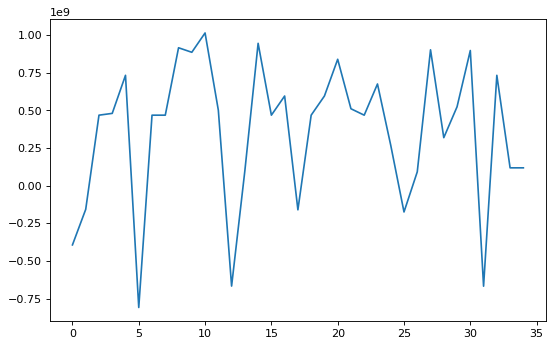

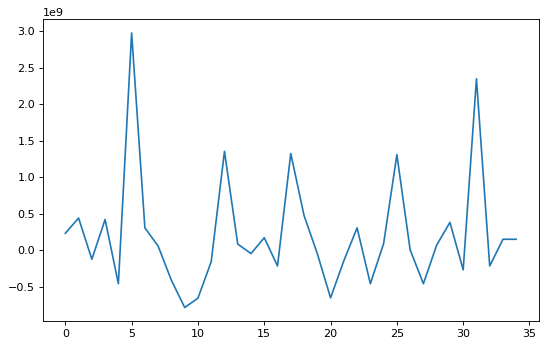

In [228]:
D1 = np.asarray(D)
for i in range(len(D1[0])):
  figure(figsize=(8, 5), dpi=80)
  plt.plot(D1[:,i])
  plt.show()

## GMM check

Text(0.5, 0, 'Crit. func.')

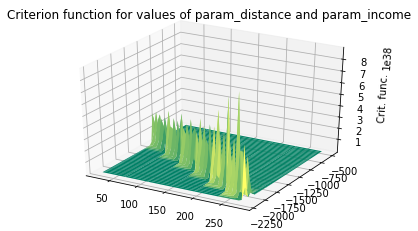

In [139]:
cmap1 = matplotlib.cm.get_cmap('summer')
p1_vals = np.linspace(-2200,-500, 50)
p2_vals = np.linspace(25, 280, 50)
crit_vals = np.zeros((50, 50))
for p1_ind in range(50):
    for p2_ind in range(50):
        crit_vals[p1_ind, p2_ind] = \
            criterion(np.array([p1_vals[p1_ind],0.0,182.375271604444,p2_vals[p2_ind],-7457.194146864454,674.1163489503457]), revs, W_hat)

p1_mesh, p2_mesh = np.meshgrid(p1_vals, p2_vals)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(p2_mesh, p1_mesh, crit_vals, rstride=8,
                cstride=1, cmap=cmap1)
ax.set_title('Criterion function for values of param_distance and param_income')
ax.set_zlabel(r'Crit. func.')

In [ ]:
crit_vals.min()

5.373272662210432e+19

In [ ]:
criterion([-2123.5585928294067, 0.0, 182.375271604444, 216.18014425698755,-7457.194146864454,674.1163489503457], revs, W_hat)

5.381409625870408e+19

In [ ]:
criterion([-810.6116819379403,0.0,76.5435460759745,83.02704647186954,-3048.877753188517,275.5364490003797], revs, W_hat)

5.383311851672377e+19

In [ ]:
#generate different datasets
seeds = np.random.randint(1, 10000, 10)
C, Sh, Me, E = [],[],[],[]
for seed in seeds: 
  cons, shops, merged_conshops = data_gen(seed_m=seed)
  C.append(cons)
  Sh.append(shops)
  Me.append(merged_conshops)

In [ ]:
for m in Me: 
  E.append(util_sum(m))

In [ ]:
R_, M_, D_= [], [], []
init_params =list(np.zeros(6))

In [ ]:
k = 0
while k < 10:
  r = gmm_opt(init_params) 
  R_.append(list(r))
  d = data_moms[0]-fict_moms[0]
  D_.append(d)
  if abs(d) > 100:
    init_params = list(r)
    M_.append(init_params)
  else: 
    break
  k+=1

In [ ]:
store_rev = pd.DataFrame(merged_conshops.groupby('shopid')['rev_0'].sum()).reset_index()

In [ ]:
store_rev

,shopid,rev_0
0,0,1.171015e+09
1,1,1.566516e+08
2,2,6.548914e+08
3,3,5.232097e+08
4,4,1.207387e+09
5,5,5.715010e+08
6,6,1.700454e+08
7,7,4.731836e+09
8,8,1.969695e+08
9,9,3.436319e+09


## Try this one on real data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = 'drive/My Drive/term_paper/Thesis Data'

In [ ]:
merged_data = pd.read_csv(path + '/merged_data.csv', index_col = 0)

In [ ]:
dist = pd.read_csv(path + '/dist.csv', index_col = 0)

In [ ]:
dist

,INDEX,shopid,km
0,195298,19867,28.347708
1,196631,19867,7.409737
2,195197,19867,31.874778
3,197022,19867,32.206271
4,197110,19867,32.393798
...,...,...,...
450523,195160,3733,5.539858
450524,196006,3733,10.189169
450525,198099,3733,10.226677
450526,199026,3733,7.164124


In [ ]:
fdata = merger(dist, merged_data, ['shopid'], ['shopid'], 'inner')

# Adjusted old model

Здесь я несколько исправил старый код, который выдал неплохой результат для некоторых параметров (например, альфа очень близка к 0.3)

In [ ]:
import torch
from torch import nn, optim

In [ ]:
class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()
        gamma1, gamma2, gamma3, gamma4, gamma5, gamma6, alpha = torch.tensor([1.]),torch.tensor([1.]),torch.tensor([1.]),torch.tensor([1.]), torch.tensor([1.]), torch.tensor([1.]), torch.tensor([1.])
        self.gamma1 = nn.Parameter(gamma1)
        self.gamma2 = nn.Parameter(gamma2)
        self.gamma3 = nn.Parameter(gamma3)
        self.gamma4 = nn.Parameter(gamma4)
        self.gamma5 = nn.Parameter(gamma5)
        self.gamma6 = nn.Parameter(gamma6)
        self.alpha = nn.Parameter(alpha)


    def forward(self, data):
        km = torch.tensor(data['km'].values.reshape(-1, 1))
        vehicle = torch.tensor(data['vehicle'].values.reshape(-1, 1)) 
        km_vehicle = torch.tensor(data['dist*vehicle'].values.reshape(-1, 1))
        dist_inc = torch.tensor(data['dist*log(inc)'].values.reshape(-1, 1))
        size = torch.tensor(data['log(size)'].values.reshape(-1, 1))
        size_inc = torch.tensor(data['log(size)*log(inc)'].values.reshape(-1, 1))
        income = torch.tensor(data['income'].values.reshape(-1, 1))
        pop = torch.tensor(data['population'].values.reshape(-1, 1))
        util = self.gamma1 * km + self.gamma2 * vehicle * self.gamma3 * km_vehicle + self.gamma4 * dist_inc + self.gamma5 * size + self.gamma6 * size_inc #torch.kron(cons_dem, store_char) # receiving a dimension error        
        u = util.reshape(100, -1)
        m = nn.Softmax(dim=1)
        R_st = m(u).reshape(-1,1) * income * pop  * self.alpha
        adjR_st = torch.sum(R_st.reshape(100, -1), dim=0)
        R = adjR_st.reshape(-1,1)
        return R

class func_loss(nn.Module):
  def __init__(self):
      super(func_loss, self).__init__()
      self.mse = nn.MSELoss()
      
  def forward(self, pred, actual):
      return self.mse(pred, actual)

model = Model()
criterion = func_loss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses, preds = [], []
for epoch in range(500000):
    pred_y = model(data)
    loss  = criterion(pred_y, torch.tensor(np.array(revs).reshape(-1, 1))) #idk what else to use
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy().item())

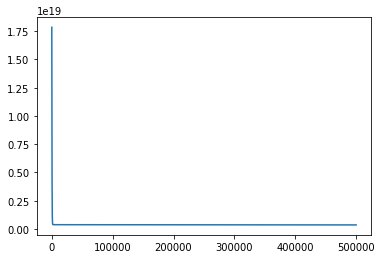

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [ ]:
#derive the params
param_list = [model.gamma1.detach().numpy().item()]
param_list

[-467.92108154296875]

https://apmonitor.com/do/index.php/Main/TCLabD

In [ ]:
pred_y

tensor([[7.3363e+08],
        [1.6742e+09],
        [5.5682e+08],
        [9.2334e+08],
        [1.0417e+09],
        [1.4429e+09],
        [1.4714e+09],
        [1.6056e+09],
        [1.1738e+09],
        [9.2506e+08]], dtype=torch.float64, grad_fn=<ReshapeAliasBackward0>)

In [ ]:
np.asarray(revs)/100000000

array([21.1556363 ,  9.88871876,  8.97769723, 10.29939901, 18.73242349,
        9.73729771, 17.81080011, 12.68827755,  9.0769082 ,  9.83109528])